Customer Id             0
YearOfObservation       0
Insured_Period          0
Residential             0
Building_Painted        0
Building_Fenced         0
Garden                  7
Settlement              0
Building Dimension    106
Building_Type           0
Date_of_Occupancy     508
NumberOfWindows         0
Geo_Code              102
Claim                   0
dtype: int64
(7160, 14)
     Customer Id  YearOfObservation  Insured_Period  Residential  \
0         H14663               2013        1.000000            0   
1          H2037               2015        1.000000            0   
2          H3802               2014        1.000000            0   
3          H3834               2013        1.000000            0   
4          H5053               2014        1.000000            0   
...          ...                ...             ...          ...   
7155       H5290               2012        1.000000            1   
7156       H5926               2013        1.000000            0   


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


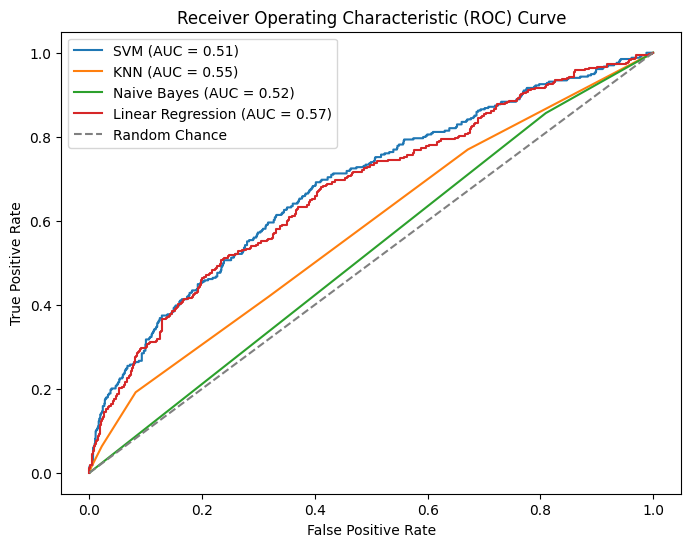

In [1]:
from sklearn import svm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score,mean_squared_error, r2_score,classification_report,roc_curve, auc, confusion_matrix
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_classification
from sklearn.metrics import roc_curve, roc_auc_score




#  Data Exploration and Preprocessing:

# Reading the dataset
raw_data = pd.read_csv('train_data.csv')
raw_data.head()

# Returns all columns and shows the sum of null values in each column
print(raw_data.isnull().sum())
print(raw_data.shape)

# Create a DataFrame
df = pd.DataFrame(raw_data)

# Handling Missing Values

# Imputation strategies
# Garden: Categorical - Impute missing values with the most frequent value (mode)
df['Garden'].fillna(df['Garden'].mode()[0], inplace=True)

# Building Dimension: Numerical - Impute missing values with the mean
df['Building Dimension'].fillna(df['Building Dimension'].mean(), inplace=True)

# Date_of_Occupancy: Numerical - Impute missing values with a representative value (e.g., median) or separate category
# For illustration, we'll fill NaN values with a constant indicating missing data
df['Date_of_Occupancy'].fillna('Not Available', inplace=True)

# Geo_Code: Categorical/Numerical - Impute missing values with the most frequent value (mode) for categorical
df['Geo_Code'].fillna(df['Geo_Code'].mode()[0], inplace=True)

# Show the updated DataFrame after imputation
print(df)

# Encoding Categorical Variables with One-Hot Encoding

# Apply One-Hot Encoding to the categorical columns
df = pd.get_dummies(df, columns=['Customer Id','Residential', 'Building_Painted', 'Building_Fenced', 'Garden', 'Settlement', 'Date_of_Occupancy','NumberOfWindows','Geo_Code'], drop_first=True)


# Concatenate the one-hot encoded columns with the original DataFrame
df_concat = pd.concat([df, df], axis=1)
print('Encoded Dataset')
print(df_concat)

# Scaling Numerical Variables
# scale features
scaler = MinMaxScaler()
df_concat[['YearOfObservation','Building Dimension']] = scaler.fit_transform(df_concat[['YearOfObservation','Building Dimension']])

print('Scaling Dataset')
print(df_concat)

# Feature Selection

# Select non-numeric columns and convert them to numerical representation
non_numeric_columns = df.select_dtypes(exclude='number').columns

for col in non_numeric_columns:
    label_encoder = LabelEncoder()
    df[col + '_encoded'] = label_encoder.fit_transform(df[col])

# # Perform feature selection using SelectKBest with the f_classif scoring function
numeric_df = df_concat.select_dtypes(include='number')
numeric_features = numeric_df.drop('Claim', axis=1)  # Drop the target variable 'Claim'


# Calculating mutual information between each feature and the target variable
mutual_info = SelectKBest(score_func=mutual_info_classif, k="all")
mutual_info.fit(numeric_features, df['Claim'])

# Geting feature scores and names
feature_scores = mutual_info.scores_
feature_names = numeric_features.columns

# Creating a DataFrame to display feature scores
feature_scores_df = pd.DataFrame({"Feature": feature_names, "Mutual_Info_Score": feature_scores})

# Sorting features by their mutual information scores in descending order
feature_scores_df = feature_scores_df.sort_values(by="Mutual_Info_Score", ascending=False)

# Display the top features
print("Top Features:")
print(feature_scores_df)

# Model Building

# Using  SVM
# Assuming X contains your features and y contains the target labels
X = df_concat.drop(columns=["Claim"])
y = df["Claim"]


# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create SVM classifier (for example, using a linear kernel)
svm_classifier = SVC(kernel='linear', C=1.0)  # You can change parameters here

# Train the SVM model
svm_classifier.fit(X_train, y_train)

# Make predictions on the test set
predictions = svm_classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, predictions)
print('Model Building with SVM')
print("Accuracy:", accuracy)

# Create a DataFrame with actual labels and predicted labels
df_predictions = pd.DataFrame({'Actual': y_test, 'Predicted': predictions})

# Save the DataFrame to a CSV file
df_predictions.to_csv('model_predictions.csv', index=False)

# # Hypertuning parameters

# # Define the parameter grid for grid search
# param_grid = {
#     'C': [0.1, 1, 10, 100],       # Regularization parameter
#     'kernel': ['linear', 'rbf'],  # Kernel type
#     'gamma': [0.1, 1, 10, 'auto']  # Kernel coefficient for 'rbf'
# }

# # Create an SVM classifier
# svm_classifier = SVC()

# # Create a GridSearchCV object
# grid_search = GridSearchCV(svm_classifier, param_grid, cv=5, scoring='accuracy')

# # Fit the grid search to the data
# grid_search.fit(X_train, y_train)

# # Print the best hyperparameters
# print("Best Hyperparameters:", grid_search.best_params_)

# # Make predictions on the test set using the best model
# best_model = grid_search.best_estimator_
# predictions = best_model.predict(X_test)

# # Calculate accuracy
# accuracy = accuracy_score(y_test, predictions)
# print("Accuracy:", accuracy)

# Using Linear Regression

# 3. Split the data into features (X) and target variable (y)


# 4. Split the data into training and testing sets


# 5. Create and train the Linear Regression model
linear_reg_model = LinearRegression()
linear_reg_model.fit(X_train, y_train)

# 6. Make predictions
predictions = linear_reg_model.predict(X_test)

# 7. Evaluate the model
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)


print('Model Building with Linear Regression')
print("Mean Squared Error:", mse)
print("R-squared:", r2)

# Using KNN

# Assuming X contains your features and y contains the target labels

# Split data into train and test sets


# Create a KNN classifier
knn_classifier = KNeighborsClassifier(n_neighbors=10)  # You can adjust the number of neighbors (k)

# Train the classifier
knn_classifier.fit(X_train, y_train)

# Make predictions on the test set
predictions = knn_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, predictions)

print('Model Building with KNN')

print("Accuracy:", accuracy)

# Additional evaluation metrics
print("Classification Report:")
print(classification_report(y_test, predictions))

# # After hypertuning with Grid Search

# # Define the parameter grid for grid search
# param_grid = {
#     'n_neighbors': [3, 5, 7, 9],          # Number of neighbors to consider
#     'weights': ['uniform', 'distance'],   # Weighting strategy
#     'p': [1, 2]                            # Power parameter for the Minkowski distance (1: Manhattan, 2: Euclidean)
# }

# # Create a GridSearchCV object
# grid_search = GridSearchCV(estimator=knn_classifier, param_grid=param_grid, cv=5, scoring='accuracy')

# # Fit the model to the training data
# grid_search.fit(X_train, y_train)

# # Get the best parameters and the best model
# best_params = grid_search.best_params_
# best_knn_model = grid_search.best_estimator_

# # Make predictions on the test set using the best model
# y_pred = best_knn_model.predict(X_test)

# # Calculate accuracy
# accuracy = accuracy_score(y_test, y_pred)
# print('After hypertuning with Grid Search')
# print("Best Parameters:", best_params)
# print("Accuracy:", accuracy)

# Using Naive Bayes

# Assuming you have your dataset in X (features) and y (labels)

# Split the dataset into training and testing sets


# Create a Gaussian Naive Bayes classifier
nb_classifier = GaussianNB()

# Train the classifier using the training data
nb_classifier.fit(X_train, y_train)

# Make predictions on the test set
predictions = nb_classifier.predict(X_test)

# Evaluate the performance of the classifier
accuracy = accuracy_score(y_test, predictions)
print('Model Building with Naive Bayes')

print("Accuracy:", accuracy)

# Display additional metrics
print("\nClassification Report:")
print(classification_report(y_test, predictions))

# Hypertuning Parameters with Grid Search

# Define the parameter grid for grid search
param_grid = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
}

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=nb_classifier, param_grid=param_grid, cv=5)

# Fit the model to the training data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Make predictions on the test set using the best model
y_pred = grid_search.predict(X_test)

# Evaluate the model performance
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Choosing best Model
# Initialize models
svm_model = SVC(probability=True)
knn_model = KNeighborsClassifier()
nb_model = GaussianNB()
lr_model = LogisticRegression()

# Train the models
svm_model.fit(X_train, y_train)
knn_model.fit(X_train, y_train)
nb_model.fit(X_train, y_train)
lr_model.fit(X_train, y_train)


svm_predictions = svm_model.predict(X_test)
knn_predictions = knn_model.predict(X_test)
nb_predictions = nb_model.predict(X_test)
lr_predictions = lr_model.predict(X_test)


# Calculate ROC and AUC for SVM
svm_fpr, svm_tpr, _ = roc_curve(y_test, svm_model.predict_proba(X_test)[:, 1])
svm_auc = roc_auc_score(y_test, svm_predictions)

# Calculate ROC and AUC for KNN
knn_fpr, knn_tpr, _ = roc_curve(y_test, knn_model.predict_proba(X_test)[:, 1])
knn_auc = roc_auc_score(y_test, knn_predictions)

# Calculate ROC and AUC for Naive Bayes
nb_fpr, nb_tpr, _ = roc_curve(y_test, nb_model.predict_proba(X_test)[:, 1])
nb_auc = roc_auc_score(y_test, nb_predictions)

# Calculate ROC and AUC for Linear Regression
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_model.predict_proba(X_test)[:, 1])
lr_auc = roc_auc_score(y_test, lr_predictions)

plt.figure(figsize=(8, 6))

# Plot ROC curve for SVM
plt.plot(svm_fpr, svm_tpr, label=f'SVM (AUC = {svm_auc:.2f})')

# Plot ROC curve for KNN
plt.plot(knn_fpr, knn_tpr, label=f'KNN (AUC = {knn_auc:.2f})')

# Plot ROC curve for Naive Bayes
plt.plot(nb_fpr, nb_tpr, label=f'Naive Bayes (AUC = {nb_auc:.2f})')

# Plot ROC curve for Linear Regression
plt.plot(lr_fpr, lr_tpr, label=f'Linear Regression (AUC = {lr_auc:.2f})')

# Plot the random chance line
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Chance')

# Add labels and legend
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

# # Model Evaluation

# # Split the dataset into training and testing sets

# # Create an SVM classifier
# svm_classifier = SVC(probability=True, kernel='linear')  # Use probability=True for ROC curve

# # Train the SVM model
# svm_classifier.fit(X_train, y_train)

# # Make probability predictions on the test set
# y_scores = svm_classifier.predict_proba(X_test)[:, 1]  # Probability of the positive class

# # Calculate ROC curve and AUC
# fpr, tpr, thresholds = roc_curve(y_test, y_scores)
# roc_auc = auc(fpr, tpr)

# # Plot ROC curve
# plt.figure()
# plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic (ROC) Curve')
# plt.legend(loc='lower right')
# plt.show()









Customer Id             0
YearOfObservation       0
Insured_Period          0
Residential             0
Building_Painted        0
Building_Fenced         0
Garden                  4
Settlement              0
Building Dimension     13
Building_Type           0
Date_of_Occupancy     728
NumberOfWindows         0
Geo_Code               13
Claim                   0
dtype: int64
(3069, 14)
     Customer Id  YearOfObservation  Insured_Period  Residential  \
0         H11920               2013        1.000000            0   
1         H11921               2016        0.997268            0   
2          H9805               2013        0.369863            0   
3          H7493               2014        1.000000            0   
4          H7494               2016        1.000000            0   
...          ...                ...             ...          ...   
3064      H11583               2015        1.000000            0   
3065      H11720               2012        1.000000            0   


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


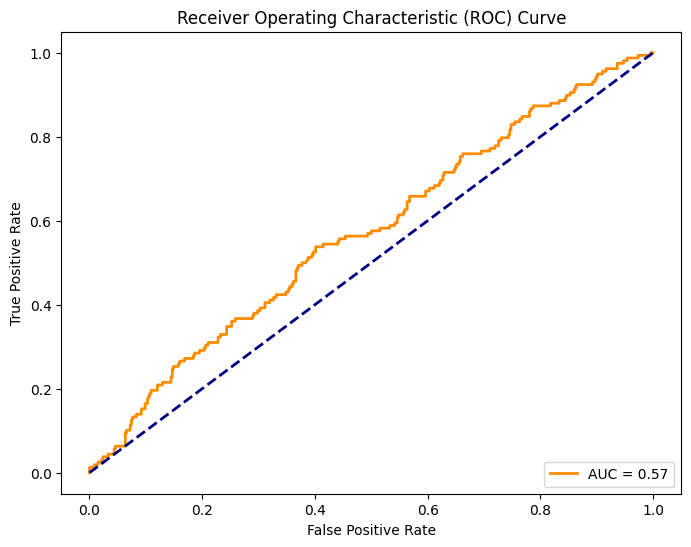

In [2]:
from sklearn import svm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score,mean_squared_error, r2_score,classification_report,roc_curve, auc
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc

# Using Test dataset
# Reading the dataset
raw_data = pd.read_csv('test_data.csv')
raw_data.head()

# Manually create or obtain labels for the dataset
# For example, you might have a CSV file with a column 'Target' containing the labels
labels = pd.read_csv('train_data.csv')['Claim']

# Add the target variable to your original dataset
raw_data['Claim'] = labels

# Returns all columns and shows the sum of null values in each column
print(raw_data.isnull().sum())
print(raw_data.shape)

# Create a DataFrame
df = pd.DataFrame(raw_data)

# Handling Missing Values

# Imputation strategies
# Garden: Categorical - Impute missing values with the most frequent value (mode)
df['Garden'].fillna(df['Garden'].mode()[0], inplace=True)

# Building Dimension: Numerical - Impute missing values with the mean
df['Building Dimension'].fillna(df['Building Dimension'].mean(), inplace=True)

# Date_of_Occupancy: Numerical - Impute missing values with a representative value (e.g., median) or separate category
# For illustration, we'll fill NaN values with a constant indicating missing data
df['Date_of_Occupancy'].fillna('Not Available', inplace=True)

# Geo_Code: Categorical/Numerical - Impute missing values with the most frequent value (mode) for categorical
df['Geo_Code'].fillna(df['Geo_Code'].mode()[0], inplace=True)

# Show the updated DataFrame after imputation
print(df)

# Encoding Categorical Variables with One-Hot Encoding

# Apply One-Hot Encoding to the categorical columns
df = pd.get_dummies(df, columns=['Customer Id','Residential', 'Building_Painted', 'Building_Fenced', 'Garden', 'Settlement', 'Date_of_Occupancy','NumberOfWindows','Geo_Code'], drop_first=True)


# Concatenate the one-hot encoded columns with the original DataFrame
df_concat = pd.concat([df, df], axis=1)
print('Encoded Dataset')
print(df_concat)

# Scaling Numerical Variables
# scale features
scaler = MinMaxScaler()
df_concat[['YearOfObservation','Building Dimension']] = scaler.fit_transform(df_concat[['YearOfObservation','Building Dimension']])

print('Scaling Dataset')
print(df_concat)

# Model Building
# # Using  SVM
# Assuming X contains your features and y contains the target labels
X = df_concat.drop(columns=["Claim"])
y = df["Claim"]

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Create SVM classifier (for example, using a linear kernel)
# svm_classifier = SVC(kernel='linear', C=1.0)  # You can change parameters here

# # Train the SVM model
# svm_classifier.fit(X_train, y_train)

# # Make predictions on the test set
# predictions = svm_classifier.predict(X_test)

# # Calculate accuracy
# accuracy = accuracy_score(y_test, predictions)
# print('Model Building with SVM')
# print("Accuracy:", accuracy)

# Using Linear Regression

# 3. Split the data into features (X) and target variable (y)


# 4. Split the data into training and testing sets


# 5. Create and train the Linear Regression model
linear_reg_model = LinearRegression()
linear_reg_model.fit(X_train, y_train)

# 6. Make predictions
predictions = linear_reg_model.predict(X_test)

# 7. Evaluate the model
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)


print('Model Building with Linear Regression')
print("Mean Squared Error:", mse)
print("R-squared:", r2)

# Creating model predictions csv

# Create a DataFrame with actual labels and predicted labels
df_predictions = pd.DataFrame({'Actual Claim': y_test, 'Predicted Claim': predictions})

# Save the DataFrame to a CSV file
df_predictions.to_csv('test_model_predictions.csv', index=False)



# Model Evaluation

# Create and train the Logistic Regression model
logistic_reg_model = LogisticRegression()
logistic_reg_model.fit(X_train, y_train)

# Make probability predictions on the test set
probabilities = logistic_reg_model.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, probabilities)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()
